#  Notebook-2 Quantum teleportation Theory and Application

Hello everyone, welcome to 2025 edition Qiskit Fall Fest at IISER, Kolkata. We begin with this notebook which will teach you the implementation of quantum teleportation protocol using actual quantum computing. Hope you have a fun time solving these exercizes.

<!-- For this Qiskit in Classrooms module, students must have a working Python environment with the following packages installed:

*   `qiskit` v2.1.0 or newer
*   `qiskit-ibm-runtime` v0.40.1 or newer
*   `qiskit-aer` v0.17.0 or newer
*   `qiskit.visualization`
*   `numpy`
*   `pylatexenc`

To set up and install the packages above, see the [Install Qiskit](/docs/guides/install-qiskit) guide.
In order to run jobs on real quantum computers, students will need to set up an account with IBM Quantum® by following the steps in the [Set up your IBM Cloud account](/docs/guides/cloud-setup) guide. -->

This module was tested and used 14 seconds of QPU time. This is an estimate only. Your actual usage may vary.



In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from collections import Counter
from qiskit_aer import AerSimulator
from qiskit import transpile


## Introduction and background

Quantum teleportation is a technique in quantum physics that allows the transfer of quantum information from one location to another without physically moving particles. Unlike the sci-fi concept of teleportation, this process doesn't involve transporting matter. Instead, it relies on the principle of quantum entanglement, where two particles become linked regardless of distance. Through a series of precise measurements and classical communication, the quantum state of one particle can be recreated in another particle at a distant location, effectively "teleporting" the quantum information. In this module, we'll see how this works mathematically, and then we will implement quantum teleportation on a real quantum computer. 
<!-- The introduction here will be brief; for more background on quantum information, and more explanation about teleportation, we recommend John Watrous's course on the [Basics of quantum information](/learning/courses/basics-of-quantum-information), and in particular the section on [Teleportation.](/learning/courses/basics-of-quantum-information/entanglement-in-action/quantum-teleportation) -->

Classical bits can be in states 0 or 1. Quantum bits (qubits) can be in quantum states denoted $|0\rangle$ and $|1\rangle$ and also linear combinations of these states, called "superpositions", such as $|\psi\rangle = \alpha_0|0\rangle +\alpha_1|1\rangle$, with $\alpha_0,\alpha_1 \in \mathbb{C},$ and $|\alpha_0|^2+|\alpha_1|^2 = 1.$ Although the states can exist in this superposition, a measurement of the state will "collapse" it into either the $|0\rangle$ or $|1\rangle$ states. The parameters $a$ and $b$ are related to the probability of each measurement outcome according to

$$
P_0 = |\alpha_0|^2
$$

$$
P_1 = |\alpha_1|^2
$$

Hence the constraint that $|\alpha_0|^2+|\alpha_1|^2 = 1.$

Another key feature is that quantum bits can be "entangled", which means that the measurement of one qubit can affect the outcome of the measurement of another, entangled qubit. Understanding how entanglement is different from simple classical correlations is a bit tricky. Let's first explain our notation. Call two qubits belonging to friend 0 (Alice) and friend 1 (Bob), and each in the $|0\rangle$ state

$$
|0\rangle_B|0\rangle_A
$$

or

$$
|0\rangle_1|0\rangle_0
$$

sometimes shortened to simply

$$
|00\rangle
$$

Note that the lowest-numbered (or lettered) qubit is furthest to the right. This is a convention called "little-endian" notation, used throughout Qiskit.
If the two-qubit state of the friends is $|00\rangle,$ and they measure the state of their respective qubits, they will each find a 0. Similarly if the qubits were in the state $|11\rangle,$ each of their measurements would yield a 1. That is no different from the classical case. However, in quantum computing, we can combine this with superposition to obtain states like

$$
\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)
$$

In a state like this, whether Alice and Bob have qubits in the state 0 or 1 is not yet known, not even yet determined by nature, and yet we know they will measure the same state for their qubit. For example, if Bob measures his qubit to be in the state $|0\rangle,$ the only way for that to happen is if the measurement has collapsed the two-qubit state to one of the two possible states, specifically to $|00\rangle.$ That leaves Alice's qubit also in the $|0\rangle$ state.

The entanglement of qubits in this way does not require that the qubits remain physically close to one another. In other words, we could entangle qubits, then separate them by a large distance, and use their entanglement to send information. An entangled state like the one above is a basic unit of entanglement, and is sometimes referred to as an "e-bit", a single bit of entanglement. These e-bits can be thought of as resources in quantum communication, since each e-bit shared between distant partners can be used, as we outline here, to move information from one location to another.

The first thought for many people learning about this for the first time is about violating relativity: can we use this to send information faster than light? By all means, keep questioning and probing scientific rules, but unfortunately this won't allow us to send information faster than light, for reasons that will become clear through the course of this module. Spoiler: amazingly it is NOT due to the speed at which this collapse propagates, which does appear to happen faster than light [\[1\]](https://www.nature.com/articles/nature15759).



We start with two collaborators Alice and Bob, who are initially in the same location and can work together on the same qubits. These collaborators will entangle their qubits. Then they will move apart to two different geographic locations, bringing their respective qubits with them. Alice will then obtain quantum information on a new qubit Q. We make no assumptions about the information on Q. The state of Q could be a secret unknown to Alice; it could be unknown to all people. But Alice is given the task of transferring the information on Q to Bob. She will do this using quantum teleportation.

To accomplish this, we will need to know some quantum operations or "gates".



<!-- ## Quantum operators (gates)

Feel free to skip this section if you are already familiar with quantum gates. If you want to understand these gates better, check out [Basics of quantum information](/learning/courses/basics-of-quantum-information), especially the first two lessons, on IBM Quantum Learning.

For this teleportation protocol we will primarily use two types of quantum gates: the Hadamard gate, the CNOT gate. A few others will play a lesser role: the $X$ gate, $Z$ gate, and the SWAP gate.

This module can be completed with very limited linear algebra background, but sometimes visualizing quantum mechanical gates using matrices and vectors can be helpful. So we present here the matrix/vector forms of quantum gates/states, as well.

The states we have already presented are chosen (partly by convention and partly by constraints) to have vector forms:

$$
|0\rangle = \begin{pmatrix}1 \\ 0\end{pmatrix}
$$

$$
|1\rangle = \begin{pmatrix}0 \\ 1\end{pmatrix}
$$

In this way, an arbitrary state $|\psi\rangle = a|0\rangle+b|1\rangle$ can be written as

$$
|\psi\rangle =\begin{pmatrix}a \\ b\end{pmatrix}
$$

There is some choice in how to extend the notation to multiple-qubit states, but the choice below is quite standard:

$$
|00\rangle = \begin{pmatrix}1 \\ 0 \\ 0 \\ 0\end{pmatrix},|01\rangle = \begin{pmatrix}0 \\ 1 \\ 0 \\ 0\end{pmatrix},
|10\rangle = \begin{pmatrix}0 \\ 0 \\ 1 \\0\end{pmatrix},|11\rangle = \begin{pmatrix}0 \\ 0 \\ 0 \\ 1\end{pmatrix}.
$$

With this choice of vector notation in mind, we can introduce our needed quantum gates, their effects on quantum states, and their matrix forms.

**H Hadamard Gate:** Creates a superposition state. Single-qubit gate.

$$
H|0\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right),
$$

$$
H|1\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle-|1\rangle\right)
$$

$$
H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$

A circuit with a Hadamard gate is made as follows:
 -->


## Theory

Let's lay out the protocol for quantum teleportation using math. Then, in the next section, we'll realize this setup using a quantum computer.

**Alice and Bob entangle their qubits:** Initially, Alice's qubit and Bob's qubit are each, separately in the $|0\rangle$ state (a fine assumption and also the correct initialization for IBM® quantum computers). We can write this as $|0\rangle_B|0\rangle_A$ or simply as $|00\rangle$. Let's calculate what happens when Alice and Bob act with the Hadamard gate on Alice's qubit, and then a CNOT gate with Alice's qubit as the control and Bob's as the target:

$$
\begin{aligned}
CNOT(A,B)H_A |0\rangle_B|0\rangle_A &= CNOT(A,B)|0\rangle_B\frac{1}{\sqrt{2}}\left(|0\rangle_A+|1\rangle_A\right)\\
&=\frac{1}{\sqrt{2}}\left(CNOT(A,B)|0\rangle_B|0\rangle_A+CNOT(A,B)|0\rangle_B|1\rangle_A\right)\\
&=\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)
\end{aligned}
$$

Note that now Alice's and Bob's qubits are entangled. Although it is not yet determined by nature whether both their qubits are in the $|0\rangle$ state or the $|1\rangle$ state, it is known that their qubits are in the same state.



**Alice and Bob separate:** The two friends move their qubits to new locations, possibly very far apart. This comes with a lot of caveats: it is not trivial to move quantum information without disturbing it. But it can be moved, and indeed you will move it in this module. But keep in mind as a caveat that we expect to encounter some errors when we move quantum information around a lot.

**Q is introduced:** The secret state is prepared on qubit Q:

$$
|\psi\rangle_Q = \alpha_0 |0\rangle_Q + \alpha_1 |1\rangle_Q
$$

At this point Q is simply adjacent to Alice's qubit (A). There has been no entanglement, so the quantum state of the three qubits together can be written as:

$$
|\psi\rangle_{AB}|\psi\rangle_Q = \frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)\left(\alpha_0 |0\rangle_Q + \alpha_1 |1\rangle_Q\right).
$$

The goal is to move the information on Q from Alice's location to the location of Bob. At this point, we are not making any claims or requirements about secrecy or speed of information transfer. We are simply exploring how information can move from Alice to Bob.



Because the information begins on Q, we will assume Q is assigned the lowest number in qubit numbers, such that little endian notation causes Q to be the right-most qubit in the math below.

**Alice entangles qubits A and Q:** Alice now operates with a CNOT gate with her own qubit as the control and Q as the target, then applies a Hadamard gate to Q.  Let's calculate the three-qubit state after that operation:

$$
\begin{aligned}
H_Q CNOT(A,Q)|\psi\rangle_{AB}|\psi\rangle_Q &= H_Q CNOT(A,Q)\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)\left(\alpha_0 |0\rangle_Q + \alpha_1 |1\rangle_Q\right)\\
&= H_Q CNOT(A,Q)\frac{1}{\sqrt{2}}\left(\left(\alpha_0 |0\rangle_B|0\rangle_A|0\rangle_Q + \alpha_1 |0\rangle_B|0\rangle_A|1\rangle_Q\right)+\left(\alpha_0 |1\rangle_B|1\rangle_A|0\rangle_Q + \alpha_1 |1\rangle_B|1\rangle_A|1\rangle_Q\right)\right)\\
&= H_Q \frac{1}{\sqrt{2}}\left(\alpha_0 |0\rangle_B|0\rangle_A|0\rangle_Q + \alpha_1 |0\rangle_B|1\rangle_A|1\rangle_Q+\alpha_0 |1\rangle_B|1\rangle_A|0\rangle_Q + \alpha_1 |1\rangle_B|0\rangle_A|1\rangle_Q\right)\\
&= \frac{1}{2}\left(\alpha_0 |0\rangle_B|0\rangle_A|0\rangle_Q + \alpha_0 |0\rangle_B|0\rangle_A|1\rangle_Q + \alpha_1 |0\rangle_B|1\rangle_A|0\rangle_Q-\alpha_1 |0\rangle_B|1\rangle_A|1\rangle_Q\right)\\
&+\frac{1}{2}\left(\alpha_0 |1\rangle_B|1\rangle_A|0\rangle_Q + \alpha_0 |1\rangle_B|1\rangle_A|1\rangle_Q + \alpha_1 |1\rangle_B|0\rangle_A|0\rangle_Q - \alpha_1 |1\rangle_B|0\rangle_A|1\rangle_Q\right)
\end{aligned}
$$



Because A and Q are in the same location, let us group the terms above according to the outcomes of measurements on qubits A and Q:

$$
\begin{aligned}
|\psi\rangle = \frac{1}{2}\left((\alpha_0 |0\rangle_B+\alpha_1 |1\rangle_B)|0\rangle_A|0\rangle_Q +  (\alpha_0 |0\rangle_B-\alpha_1 |1\rangle_B)|0\rangle_A|1\rangle_Q + (\alpha_1 |0\rangle_B+\alpha_0 |1\rangle_B)|1\rangle_A|0\rangle_Q+ (-\alpha_1 |0\rangle_B+\alpha_0 |1\rangle_B)|1\rangle_A|1\rangle_Q \right)\\
\end{aligned}
$$

#### Check your understanding

Read the question below, think about your answer, then click the triangle to reveal the solution.

<details>
  <summary>
    Given the expression above for the states of all three qubits, what is the probability that a measurement of qubits A and Q yields $|0\rangle_A|0\rangle_Q$?
  </summary>

  **Answer:**

  25%. To see this, recall that Bob's state must be normalized, so
  $ |_A \langle0|_Q\langle0| \frac{1}{2} |0\rangle_A|0\rangle_Q (\alpha_0 |0\rangle_B+\alpha_1 |1\rangle_B)|^2 = \frac{1}{4}|(\alpha_0 |0\rangle_B+\alpha_1 |1\rangle_B)|^2 = \frac{1}{4}$
</details>



Now, Alice can measure qubits A and Q . She cannot control the outcome of that measurement, since quantum measurements are probabilistic. So when she measures, there are 4 possible outcomes and all 4 are equally likely: $|0\rangle_A|0\rangle_Q,$ $|0\rangle_A|1\rangle_Q,$ $|1\rangle_A|0\rangle_Q,$ and $|1\rangle_A|1\rangle_Q.$ Note that each outcome has different implications for Bob's qubit. For example, if Alice finds her qubits to be in $|0\rangle_A|0\rangle_Q,$ that has collapsed the entire, 3-qubit quantum state to $(\alpha_0|0\rangle_B+\alpha_1|1\rangle_B)|0\rangle_A|0\rangle_Q.$ Other measurement outcomes for Alice yield different states for Bob. These are collected together in the table below.



| Alice outcome                        | Bob's state                                          | Instruction to Bob | Result                                              |
| ------------------------------------ | ---------------------------------------------------- | ------------------ | --------------------------------------------------- |
| $ \vert 0\rangle_A \vert 0\rangle_Q$ | $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$  | None               | $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$ |
| $ \vert 0\rangle_A \vert 1\rangle_Q$ | $\alpha_0\vert 0\rangle_B-\alpha_1\vert 1\rangle_B$  | $Z$                | $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$ |
| $ \vert 1\rangle_A \vert 0\rangle_Q$ | $\alpha_1\vert 0\rangle_B+\alpha_0\vert 1\rangle_B$  | $X$                | $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$ |
| $ \vert 1\rangle_A \vert 1\rangle_Q$ | $-\alpha_1\vert 0\rangle_B+\alpha_0\vert 1\rangle_B$ | $X$ then $Z$       | $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$ |



For all the possible measurement outcomes on Alice's qubits, Bob's qubit is left in a state vaguely resembling the secret state originally on Q. In the case where Alice measures $|0\rangle_C|0\rangle_A$ (the first row of the table), Bob's qubit is left in exactly the secret state! In the other cases, there is something off about the state. The coefficients ($\alpha$'s) are swapped, or there is a "-" sign where there should be a "+" sign, or both. In order to modify Bob's qubit to make it exactly equal to the secret state, Alice must call Bob (use some means of classical communication) and tell Bob to perform additional operations on his qubit, as outlined in the table. For example, in the third row the coefficients are swapped. If Alice calls Bob and tells him to apply an $X$ gate to his qubit, it changes a $|0\rangle$ to a $|1\rangle$ and vice-versa, and out comes the secret state.

It should now be clear why we can't use this setup to send information faster than light. We might get lucky and measure $|0\rangle_A|0\rangle_Q,$ meaning Bob has exactly the secret state, instantly. But Bob doesn't know that until we call him and tell him "We measured $|0\rangle_A|0\rangle_Q$, so you don't have to do anything."

In the thought experiment, the qubits are often physically separated and taken to a new location. IBM® quantum computers use solid-state qubits on a chip that can't be separated. So instead of moving Alice and Bob to different locations, we will separate the information on the chip itself by using so-called "swap gates" to move the information from one qubit to another.



## Basic teleportation

IBM Quantum recommends tackling quantum computing problems using a framework we call "Qiskit patterns". It consists of the following tasks.

*   Task 1: Map your problem to a quantum circuit
*   Task 2: Optimize your circuit for running on real quantum hardware
*   Task 3: Execute your job on IBM quantum computers using Runtime Primitives
*   Task 4: Post-process the results

### Task 1: Map your problem to a quantum circuit

All the math we did above was outlining task 1. We will implement it now, building our quantum circuit using Qiskit! We start creating a quantum circuit with three qubits, and entangling the two qubits of Alice and Bob. We will take these to be qubits 1 and 2, and we will reserve qubit 0 for the secret state.



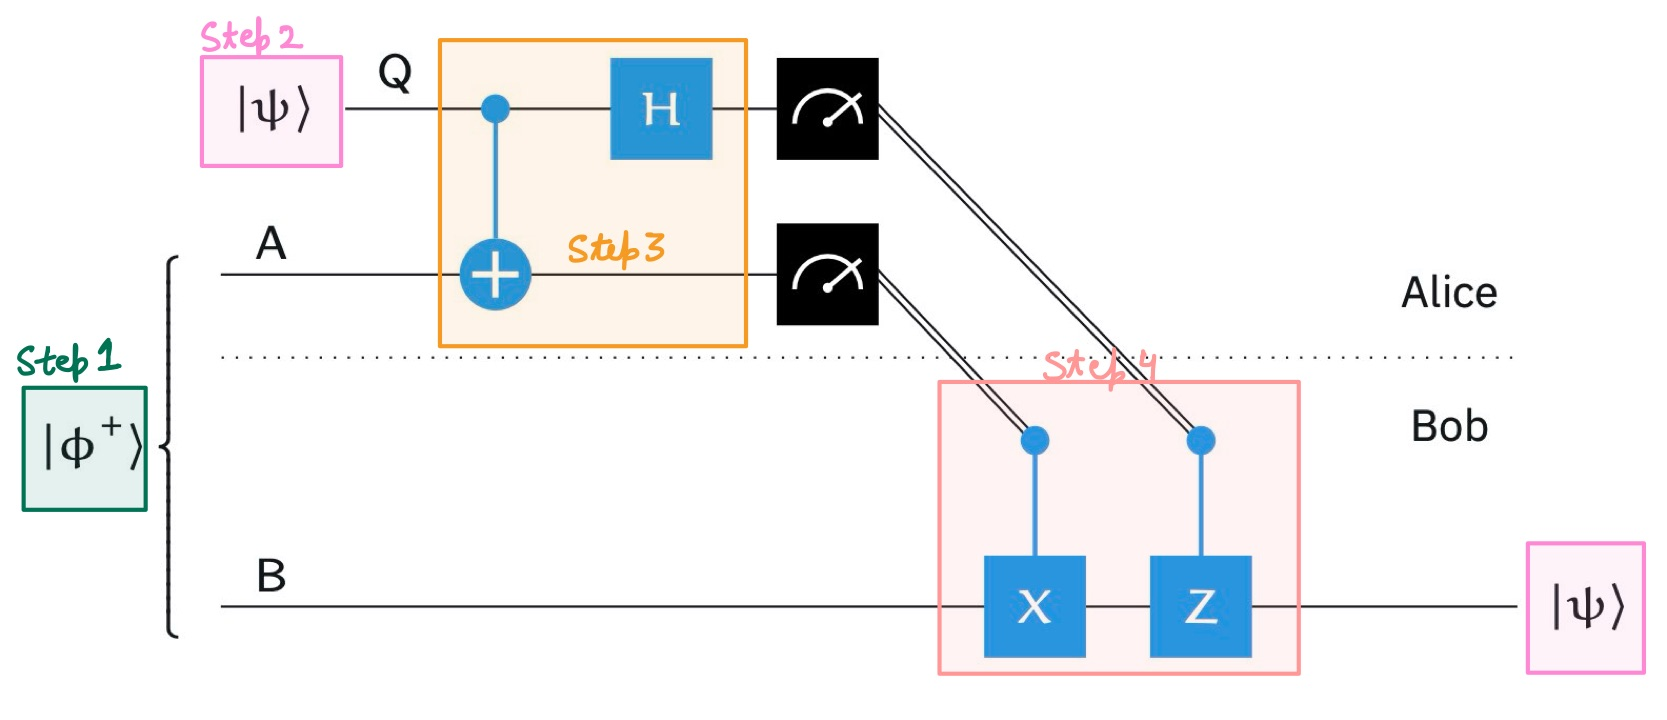

### Exercise 1: Create a 3 qubit circuit and generate qubit 1 and qubit 2 in $|\phi^+ \rangle$ state (i.e. $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$).

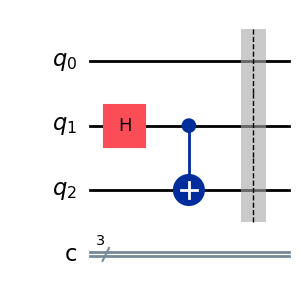

In [21]:
# Create a 3-qubit quantum circuit
qc = QuantumCircuit(3, 3)

# Step 1: Create |Φ⁺⟩ = (|00⟩ + |11⟩)/√2 between qubits 1 and 2
# (Qubit indexing starts from 0)
qc.h(1)        # Apply Hadamard gate on qubit 1
qc.cx(1, 2)    # Apply CNOT with control=1, target=2

# Optional barrier for clarity (doesn't affect logic)
qc.barrier()

# Draw the circuit
qc.draw('mpl')

### Exercise 2: Do step 2, i.e. generate a secret state $|\psi\rangle$. (use random variables for this)

Hint: Use U gate for this purpose.

U gate: The U gate in Qiskit, called by qc.u($\theta$,$\phi$,$\lambda$) is a generic single qubit rotation gate parameterized by three euler angles: $\theta$,$\phi$ and $\lambda$. It performs a rotation on the qubit state around the bloch sphere with these 3 angles. Its matrix form is:

$$
U(\theta, \phi, \lambda) = 
\begin{bmatrix}
\cos\left(\frac{\theta}{2}\right) & -e^{i\lambda} \sin\left(\frac{\theta}{2}\right) \\
e^{i\phi} \sin\left(\frac{\theta}{2}\right) & e^{i(\phi + \lambda)} \cos\left(\frac{\theta}{2}\right)
\end{bmatrix}
$$

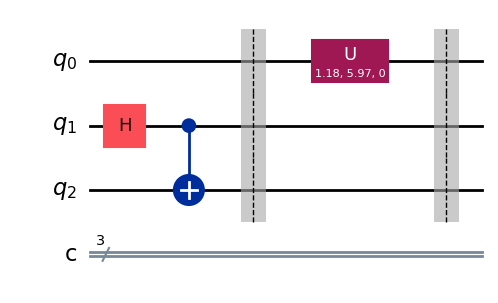

In [22]:
np.random.seed(42)  # fixing seed for repeatability
theta = np.random.uniform(0.0, 1.0) * np.pi   # random angle between 0 and π
phi = np.random.uniform(0.0, 2.0) * np.pi     # random angle between 0 and 2π
lamda = 0                                     # can set lambda = 0

# Apply U gate to qubit 0 to prepare |ψ⟩
qc.u(theta, phi, lamda, 0)

qc.barrier()
qc.draw("mpl")

### Exercise 3: Do step 3, i.e. create entanglement between Alice and secret state qubit.

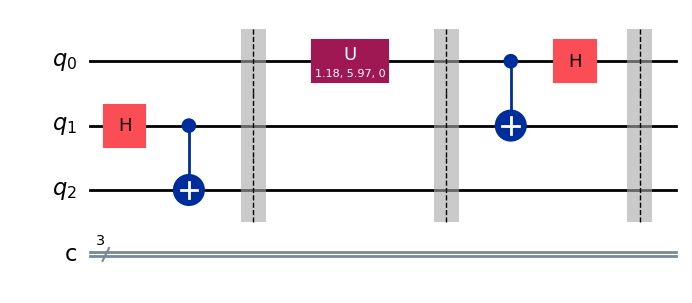

In [23]:
# Step 3: Entangle secret state (qubit 0) with Alice's qubit (qubit 1)
qc.cx(0, 1)   # CNOT: control = secret state, target = Alice’s qubit
qc.h(0)       # Apply Hadamard on the secret state qubit

qc.barrier()
qc.draw("mpl")


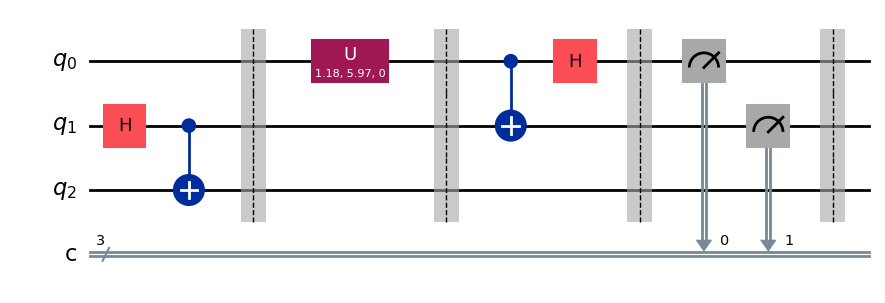

In [24]:
# Alice measures her qubits
qc.measure(0, 0)  # Measure secret qubit → classical bit 0
qc.measure(1, 1)  # Measure Alice’s entangled qubit → classical bit 1

qc.barrier()
qc.draw("mpl")

### Exercise 4: Do step 4 i.e. generate a conditional circuit.

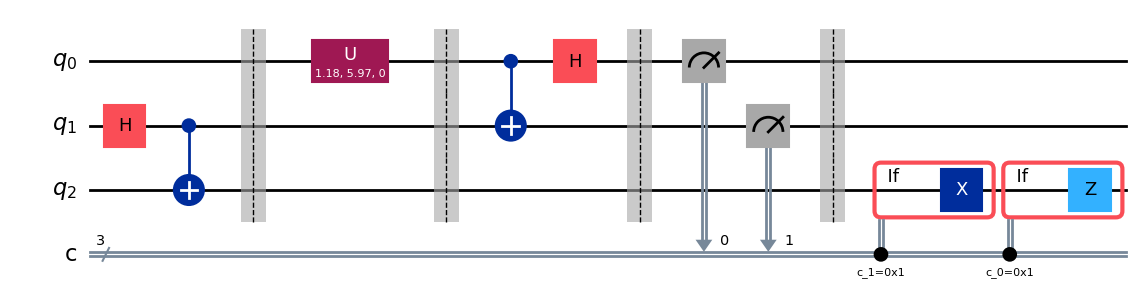

In [25]:
# Now we insert some conditional logic. If Alice measures secret state in a "1" we need a Z gate, and if Alice measures her own qubit in a "1" we need an X gate (see the table).
# Note: in if_test command first argument corresponds to the classical register and 2nd argument is what the value stored in that classical register is compared with!!
# your code goes here:
with qc.if_test((1, 1)):
    qc.x(2)
with qc.if_test((0, 1)):
    qc.z(2)

qc.draw(output="mpl")

That's all we have to do to get Alice's state teleported to Bob. However, recall that when we measure a quantum state $\alpha_0 |0\rangle+\alpha_1|1\rangle$ we find either $|0\rangle$ or $|1\rangle.$ So at the end of all this, Bob definitely has Alice's secret state, but we can't easily verify this with a measurement. In order for a measurement to tell us that we did this correctly, we have to do a trick. We had an operator labeled "U" for "unitary" which we used to prepare Alice's secret state. We can apply the inverse of U at the end of our circuit. If U mapped Alice's $|0\rangle$ state into $\alpha_0 |0\rangle+\alpha_1|1\rangle$, then the inverse of U will map Bob's $\alpha_0 |0\rangle+\alpha_1|1\rangle$ back to $|0\rangle.$ So this last part wouldn't necessarily be done if the goal were just to move quantum information. This is only done for us to check ourselves.



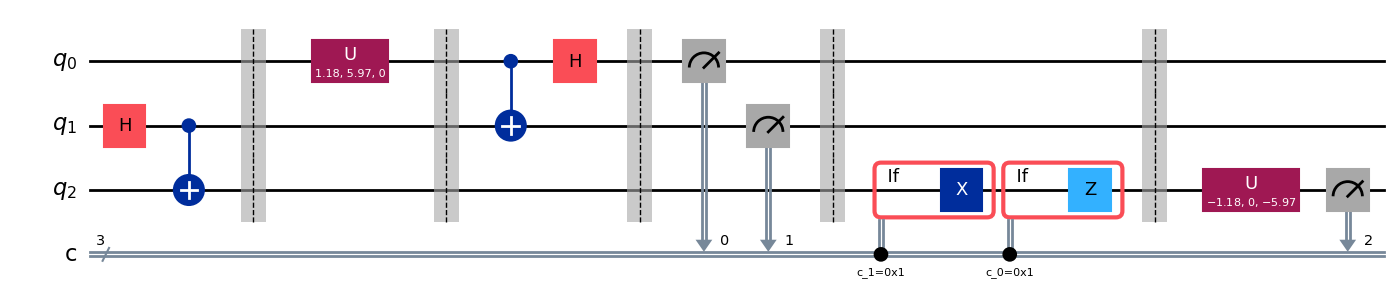

In [26]:
# Add the inverse of U and measure Bob's qubit.
qc.barrier()
# your code goes here:
  # inverse of u(theta,varphi,0.0)
  # add measurement gate
qc.u(-theta, -lamda, -phi, 2)
qc.measure(2, 2)

qc.draw(output="mpl")

In [27]:

# Create the simulator backend
simulator = AerSimulator()

# Transpile the circuit for the simulator backend
compiled_circuit = transpile(qc, simulator)

# Run the circuit on the simulator
job = simulator.run(compiled_circuit, shots=1024)

# Get the result from the job
result = job.result()

# Get measurement counts
counts = result.get_counts(compiled_circuit)

print(counts)

{'001': 242, '010': 262, '000': 241, '011': 279}


Note: We are getting the 3rd register always in zero state. (Left most register in the string) This is exactly what we expected. Hence our teleportation protocol has worked perfectly. 

In [28]:
# Below written code checks how many times was the Bob's qubit measured in what state.

# Get full counts from all 3 classical bits
full_counts = result.get_counts(compiled_circuit)

# Extract the bit from the 3rd classical register which stores the result of Bob's measurement(bit at position 0)
# Qiskit bitstrings order: c2 c1 c0 (left to right)

def extract_second_register_bit(bitstring):
    return bitstring[0]  # 0 corresponds to index 1 from the left i.e. 3rd classical register in the bitstring

# Aggregate counts by the extracted bit
counts_second_register = Counter()
for bits, count in full_counts.items():
    bit = extract_second_register_bit(bits)
    counts_second_register[bit] += count

print(dict(counts_second_register))

{'0': 1024}


### Congrats you have learnt and implemented a real life quantum protocol i.e. Quantum Teleportation.